In [2]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.model_selection import  GridSearchCV, TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, make_scorer



In [3]:
# transforms the prportion using logarithm in ordere to make predictions easier
def LogarithmProportion(row, column_name):
    p = row[column_name]
    return np.log(p/(1-p))

In [4]:

df = pd.read_csv(r".\data\merged_PAS_Crine.csv")
df['Proportion'] = df.apply(lambda row: LogarithmProportion(row, "Proportion"), axis=1)

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [6]:
df.head()

,Anti-social behaviour,Other crime,Burglary,Vehicle crime,Robbery,Other theft,Criminal damage and arson,Drugs,Shoplifting,Violence and sexual offences,Theft from the person,Public order,Bicycle theft,Possession of weapons,Proportion
Date,,,,,,,,,,,,,,,
2015-04-01,18327,685,5375,6569,1766,8457.0,5078.0,2591.0,3679.0,13536.0,3013.0,3302.0,1407.0,283.0,1.815290
2015-05-01,19630,706,5524,6993,1882,9245.0,5348.0,2658.0,3627.0,15058.0,3200.0,3504.0,1663.0,285.0,1.900959
2015-06-01,21392,734,5245,7261,1707,9383.0,5260.0,2780.0,3515.0,16562.0,2686.0,3720.0,1696.0,318.0,1.900959
2015-07-01,23311,757,5368,6630,1764,9821.0,5405.0,2922.0,3430.0,17432.0,2650.0,3793.0,1762.0,316.0,1.992430
2015-08-01,21826,683,5343,6454,1771,8927.0,4935.0,2961.0,3422.0,16176.0,2366.0,3561.0,1475.0,329.0,1.992430


In [7]:
def create_features(df):
    """
    Cretes time series features based on time series index.

    """
    df = df.copy()

    df['year'] = df.index.year
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    return df

df = create_features(df)


In [8]:
df.head()

,Anti-social behaviour,Other crime,Burglary,Vehicle crime,Robbery,Other theft,Criminal damage and arson,Drugs,Shoplifting,Violence and sexual offences,Theft from the person,Public order,Bicycle theft,Possession of weapons,Proportion,year,month,quarter
Date,,,,,,,,,,,,,,,,,,
2015-04-01,18327,685,5375,6569,1766,8457.0,5078.0,2591.0,3679.0,13536.0,3013.0,3302.0,1407.0,283.0,1.815290,2015,4,2
2015-05-01,19630,706,5524,6993,1882,9245.0,5348.0,2658.0,3627.0,15058.0,3200.0,3504.0,1663.0,285.0,1.900959,2015,5,2
2015-06-01,21392,734,5245,7261,1707,9383.0,5260.0,2780.0,3515.0,16562.0,2686.0,3720.0,1696.0,318.0,1.900959,2015,6,2
2015-07-01,23311,757,5368,6630,1764,9821.0,5405.0,2922.0,3430.0,17432.0,2650.0,3793.0,1762.0,316.0,1.992430,2015,7,3
2015-08-01,21826,683,5343,6454,1771,8927.0,4935.0,2961.0,3422.0,16176.0,2366.0,3561.0,1475.0,329.0,1.992430,2015,8,3


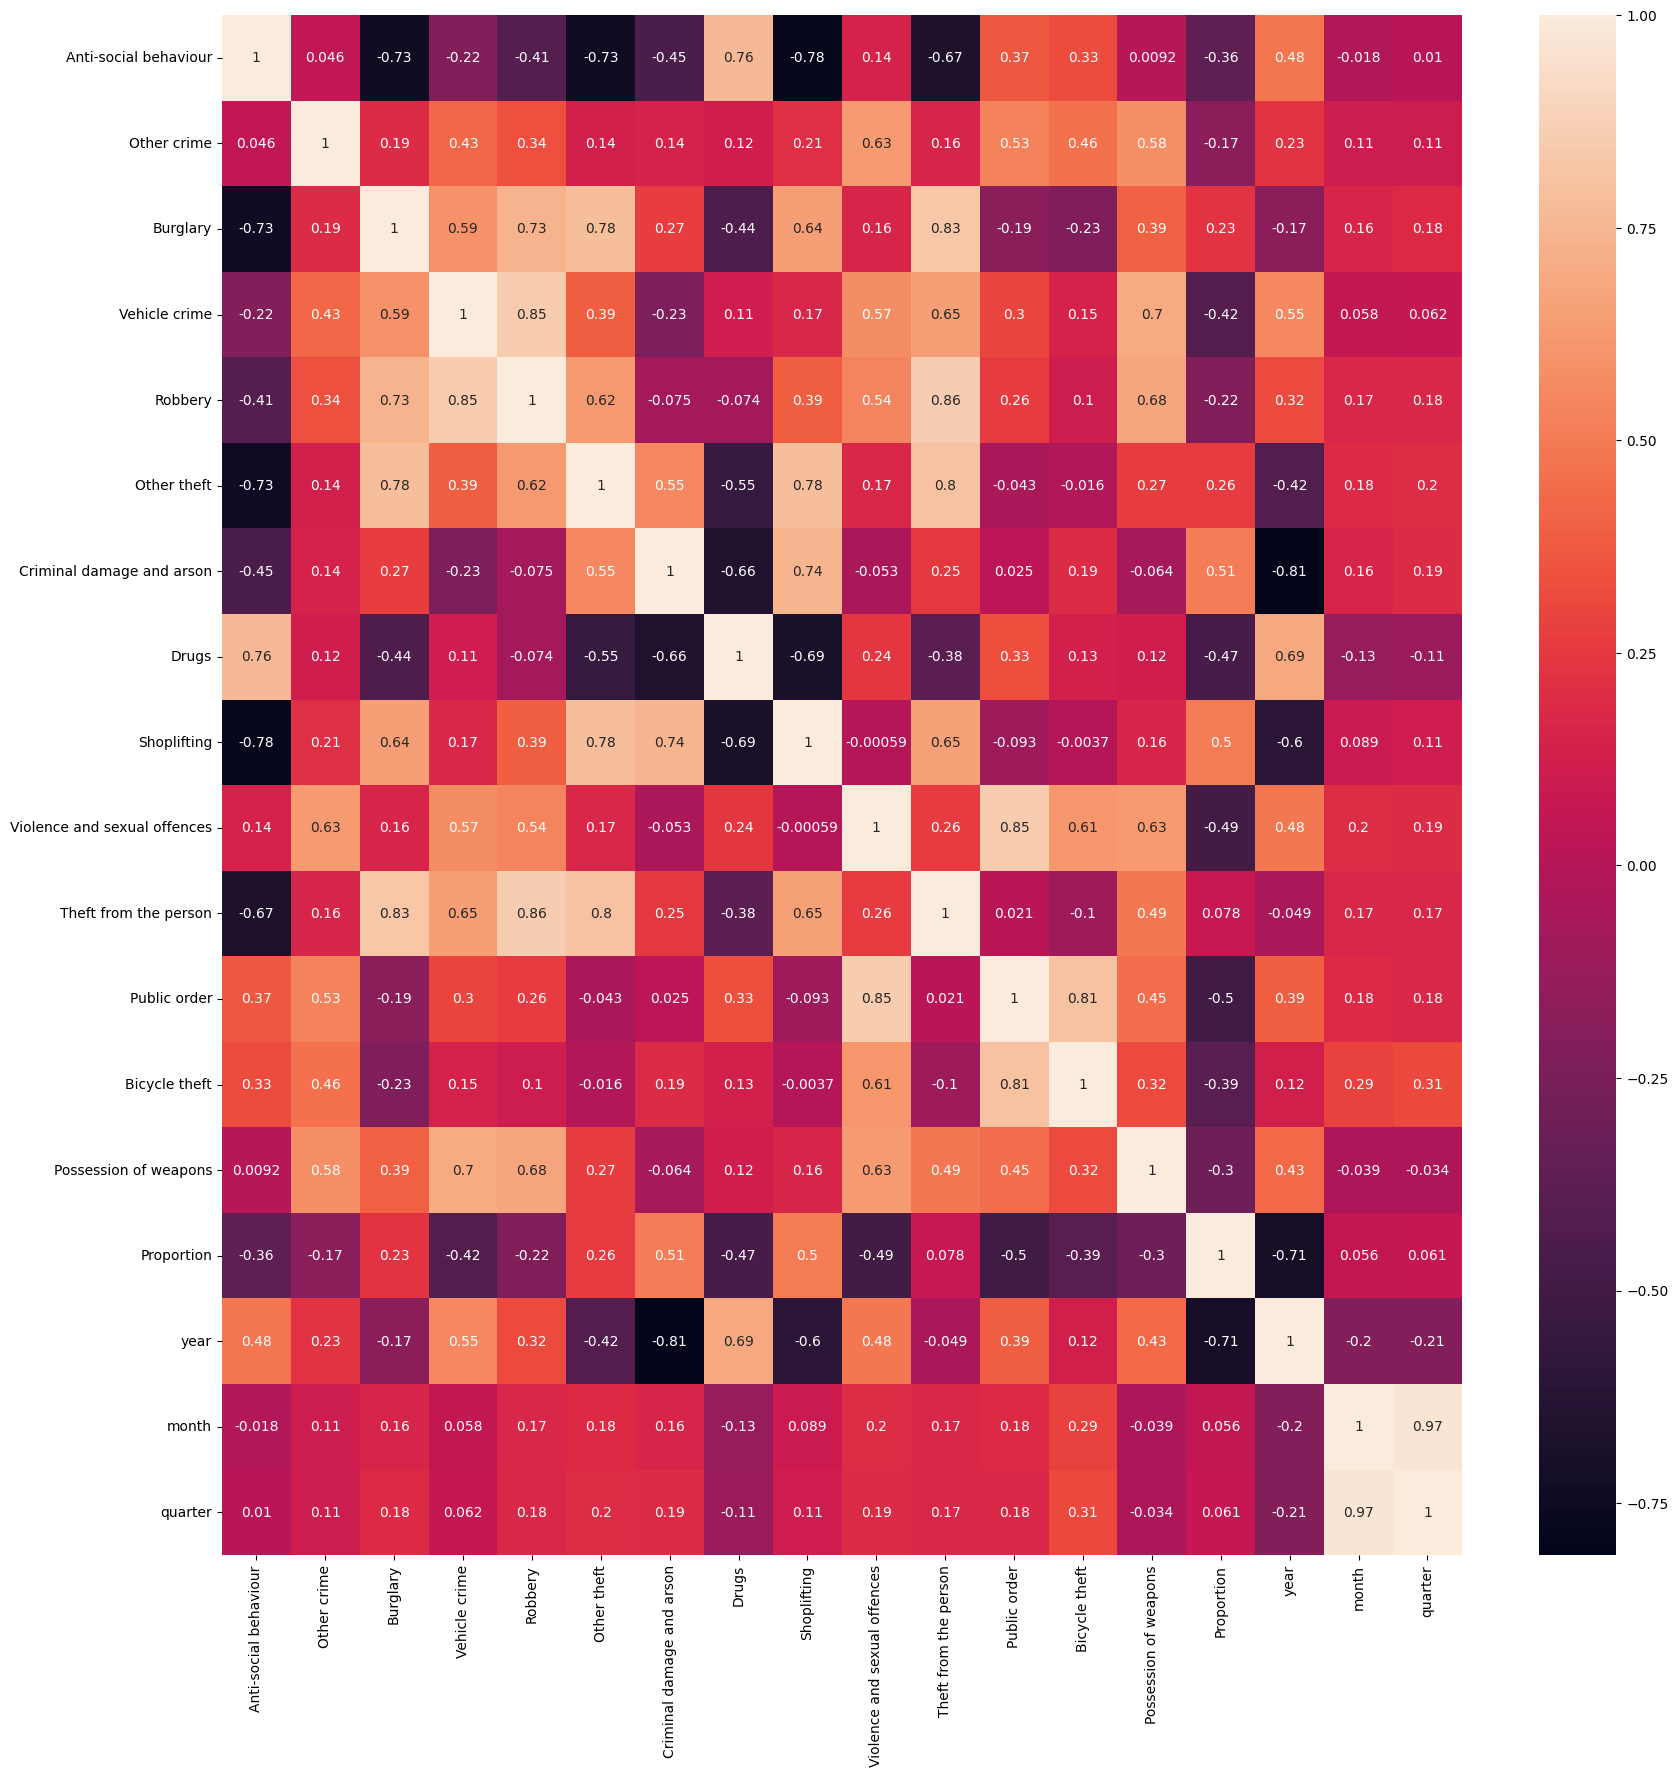

In [9]:
# getting correlation

corr = df.corr()
top_corr_feat = corr.index
plt.figure(figsize=(20,20))

g = sns.heatmap(df[top_corr_feat].corr(), annot=True)

In [10]:

df.sort_index()

df['lag_1'] = df['Proportion'].shift(1)  # 1-month lag
df['lag_2'] = df['Proportion'].shift(2)  # 2- month lag
df['lag_3'] = df['Proportion'].shift(3)  # 1-month lag

df1 = df.iloc[:58].copy() # training_set
df2 = df.iloc[58:].copy()

df1.shape, df2.shape
# X = df.loc[:, df.columns != "Proportion"]
# Y = df[["Proportion"]]


((58, 21), (12, 21))

# K fold for XGboost

In [11]:

# Assuming df1 is your DataFrame with time series data

tss_1 = TimeSeriesSplit(n_splits=3, test_size=5)

# Define features and target
FEATURES = ['quarter', 'year', 'month','Criminal damage and arson', 'Drugs', 'Public order',
        'Violence and sexual offences', 'Shoplifting', 'Bicycle theft',
        'Anti-social behaviour', 'lag_1', 'lag_2', 'lag_3']
TARGET = "Proportion"

# Define XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=20)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Make RMSE scorer for GridSearchCV (lower RMSE is better, so greater_is_better=False)
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Define parameter grid for GridSearchCV
param_grid = {

    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.1 ,0.5, 1],
    'subsample': [0.5, 0.6, 0.8, 1.0],
    'colsample_bytree': [0.5,0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5],
    'reg_lambda' : [0.01, 0.1, 0.5, 1.0,2,5,10.0]
    
}

# Perform GridSearchCV with TimeSeriesSplit cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=tss_1, verbose=1, n_jobs=-1, scoring=rmse_scorer)

# Split data into features and target
X = df1[FEATURES]
y = df1[TARGET]

# Fit GridSearchCV on data
grid_search.fit(X, y)

# Access best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found by GridSearchCV:")
print(best_params)
print(f"Best score: {best_score}")


Fitting 3 folds for each of 4032 candidates, totalling 12096 fits
Best parameters found by GridSearchCV:
{'colsample_bytree': 0.8, 'gamma': 0, 'max_depth': 5, 'min_child_weight': 1, 'reg_lambda': 1.0, 'subsample': 0.6}
Best score: -0.0897529329641054


In [14]:
df

,Anti-social behaviour,Other crime,Burglary,Vehicle crime,Robbery,Other theft,Criminal damage and arson,Drugs,Shoplifting,Violence and sexual offences,...,Public order,Bicycle theft,Possession of weapons,Proportion,year,month,quarter,lag_1,lag_2,lag_3
Date,,,,,,,,,,,,,,,,,,,,,
2015-04-01,18327,685,5375,6569,1766,8457.0,5078.0,2591.0,3679.0,13536.0,...,3302.0,1407.0,283.0,1.815290,2015,4,2,NaN,NaN,NaN
2015-05-01,19630,706,5524,6993,1882,9245.0,5348.0,2658.0,3627.0,15058.0,...,3504.0,1663.0,285.0,1.900959,2015,5,2,1.815290,NaN,NaN
2015-06-01,21392,734,5245,7261,1707,9383.0,5260.0,2780.0,3515.0,16562.0,...,3720.0,1696.0,318.0,1.900959,2015,6,2,1.900959,1.815290,NaN
2015-07-01,23311,757,5368,6630,1764,9821.0,5405.0,2922.0,3430.0,17432.0,...,3793.0,1762.0,316.0,1.992430,2015,7,3,1.900959,1.900959,1.815290
2015-08-01,21826,683,5343,6454,1771,8927.0,4935.0,2961.0,3422.0,16176.0,...,3561.0,1475.0,329.0,1.992430,2015,8,3,1.992430,1.900959,1.900959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-01,33833,964,5186,9096,2267,5663.0,4183.0,4360.0,2757.0,18697.0,...,4200.0,1976.0,506.0,1.658228,2020,11,4,1.450010,1.516347,1.585627
2020-12-01,29358,768,4740,7686,2002,6247.0,4062.0,3572.0,2679.0,17563.0,...,3848.0,1303.0,383.0,1.585627,2020,12,4,1.658228,1.450010,1.516347
2021-01-01,33611,727,4261,7629,1436,4776.0,3613.0,3644.0,2086.0,16048.0,...,3418.0,1048.0,345.0,1.658228,2021,1,1,1.585627,1.658228,1.450010


In [21]:
tss_2 = TimeSeriesSplit(n_splits=3, test_size=4)

# small hand adjusting to avoid overfitting

df.sort_index()
# for now we don not include lags as we are missing two months

fold = 0
preds = []
scores = []

for train_idx, val_idx in tss_2.split(df):

       train = df.iloc[train_idx]
       test = df.iloc[val_idx]

       FEATURES = ['quarter', 'year', 'month','Criminal damage and arson', 'Drugs', 'Public order',
              'Violence and sexual offences', 'Shoplifting', 'Bicycle theft',
              'Anti-social behaviour', 'lag_1', 'lag_2', 'lag_3']
       TARGET = "Proportion"

       X_train = train[FEATURES]
       y_train = train[TARGET]

       X_test = test[FEATURES]
       y_test = test[TARGET]

       xgb_model = XGBRegressor(colsample_bytree= 0.8, eta= 0.08, gamma=0, max_depth= 5, min_child_weight = 1, subsample =0.6, reg_lambda = 1, 
                                objective='reg:squarederror', random_state=42, n_estimators=20)
       
       xgb_model.fit(X_train, y_train, eval_set=[(X_train,y_train), (X_test,y_test)], verbose=1)
       y_pred = xgb_model.predict(X_test)
       preds.append(y_pred)
       score = np.sqrt(mean_squared_error(y_test, y_pred))
       scores.append(score)

[0]	validation_0-rmse:0.16630	validation_1-rmse:0.34700
[1]	validation_0-rmse:0.16014	validation_1-rmse:0.34277
[2]	validation_0-rmse:0.15455	validation_1-rmse:0.34029
[3]	validation_0-rmse:0.14683	validation_1-rmse:0.33624


[4]	validation_0-rmse:0.13978	validation_1-rmse:0.33122
[5]	validation_0-rmse:0.13258	validation_1-rmse:0.32692
[6]	validation_0-rmse:0.12724	validation_1-rmse:0.32403
[7]	validation_0-rmse:0.12158	validation_1-rmse:0.32778
[8]	validation_0-rmse:0.11747	validation_1-rmse:0.32767
[9]	validation_0-rmse:0.11113	validation_1-rmse:0.32784
[10]	validation_0-rmse:0.10588	validation_1-rmse:0.32741
[11]	validation_0-rmse:0.10078	validation_1-rmse:0.32746
[12]	validation_0-rmse:0.09650	validation_1-rmse:0.32433
[13]	validation_0-rmse:0.09160	validation_1-rmse:0.32435
[14]	validation_0-rmse:0.08814	validation_1-rmse:0.32291
[15]	validation_0-rmse:0.08474	validation_1-rmse:0.31981
[16]	validation_0-rmse:0.08219	validation_1-rmse:0.31805
[17]	validation_0-rmse:0.07969	validation_1-rmse:0.31588
[18]	validation_0-rmse:0.07719	validation_1-rmse:0.31645
[19]	validation_0-rmse:0.07468	validation_1-rmse:0.31071
[0]	validation_0-rmse:0.18127	validation_1-rmse:0.37351
[1]	validation_0-rmse:0.17569	validati

In [22]:
print(f'Score acreoss folds {np.mean(scores):0.4f}')
print(f'fold scores{scores}')


Score acreoss folds 0.2879
fold scores[0.31070541389841544, 0.24384074610766207, 0.3091082524265547]


In [118]:
df1 = df.iloc[:58].copy() # training_set
df2 = df.iloc[58:].copy()

df1.index

DatetimeIndex(['2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01',
               '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01',
               '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01',
               '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01',
               '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01',
               '2016-12-01', '2017-01-01', '2017-04-01', '2017-05-01',
               '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01',
               '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01',
               '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01',
               '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01',
               '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
      

In [34]:


train = df.iloc[:66]
test = df.iloc[66:]

FEATURES = ['quarter', 'year', 'month','Criminal damage and arson', 'Drugs', 'Public order',
        'Violence and sexual offences', 'Shoplifting', 'Bicycle theft',
        'Anti-social behaviour', 'lag_1', 'lag_2', 'lag_3']
TARGET = "Proportion"

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

xgb_model = XGBRegressor(colsample_bytree= 0.8, eta= 0.01, gamma=0, max_depth= 5, min_child_weight = 1, subsample =0.6, reg_lambda = 1, 
                        objective='reg:squarederror', random_state=42, n_estimators=20)

xgb_model.fit(X_train, y_train, eval_set=[(X_train,y_train), (X_test,y_test)], verbose=1)
y_pred = xgb_model.predict(X_test)

score = np.sqrt(mean_squared_error(y_test, y_pred))
print(score)

[0]	validation_0-rmse:0.20401	validation_1-rmse:0.37602
[1]	validation_0-rmse:0.20308	validation_1-rmse:0.37396
[2]	validation_0-rmse:0.20206	validation_1-rmse:0.37083
[3]	validation_0-rmse:0.20064	validation_1-rmse:0.37073
[4]	validation_0-rmse:0.19906	validation_1-rmse:0.36931
[5]	validation_0-rmse:0.19767	validation_1-rmse:0.36778
[6]	validation_0-rmse:0.19664	validation_1-rmse:0.36648
[7]	validation_0-rmse:0.19519	validation_1-rmse:0.36554
[8]	validation_0-rmse:0.19410	validation_1-rmse:0.36429
[9]	validation_0-rmse:0.19271	validation_1-rmse:0.36325
[10]	validation_0-rmse:0.19146	validation_1-rmse:0.36332
[11]	validation_0-rmse:0.19031	validation_1-rmse:0.36267
[12]	validation_0-rmse:0.18915	validation_1-rmse:0.36275
[13]	validation_0-rmse:0.18800	validation_1-rmse:0.36154
[14]	validation_0-rmse:0.18676	validation_1-rmse:0.36058
[15]	validation_0-rmse:0.18546	validation_1-rmse:0.35998
[16]	validation_0-rmse:0.18468	validation_1-rmse:0.36006
[17]	validation_0-rmse:0.18363	validation

# Plotting the prediction




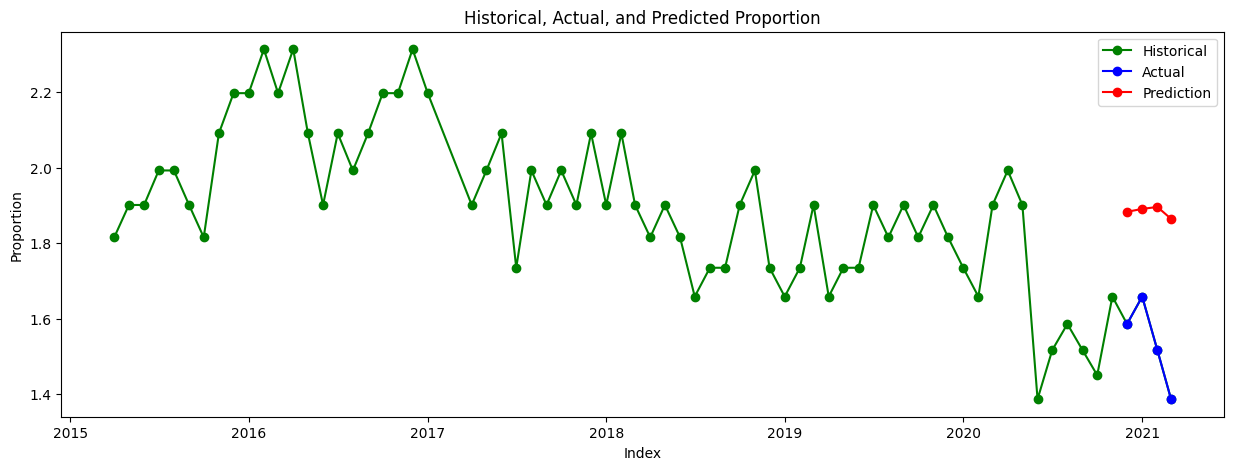

In [38]:

# Concatenate train and test data
historical_data = pd.concat([train, test])

# Copy the test data and add predictions
test_simple = test.copy()
test_simple['prediction'] = y_pred

# Plot actual data and predictions
plt.figure(figsize=(15, 5))
plt.plot(historical_data.index, historical_data['Proportion'], marker='o', linestyle='-', color='g', label='Historical')
plt.plot(test_simple.index, test_simple['Proportion'], marker='o', linestyle='-', color='b', label='Actual')
plt.plot(test_simple.index, test_simple['prediction'], marker='o', linestyle='-', color='r', label='Prediction')

# Set labels and title
plt.xlabel('Index')  # You can customize this to your needs (e.g., date/time if applicable)
plt.ylabel('Proportion')
plt.title('Historical, Actual, and Predicted Proportion of Trust')
plt.legend()

plt.show()




# Feature importance

In [39]:
feature_importances = xgb_model.feature_importances_

# Create a DataFrame to display the feature importances
feature_importance_df = pd.DataFrame({
    'Feature': FEATURES,
    'Importance': feature_importances
})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the sorted feature importances
print(feature_importance_df)          


                         Feature  Importance
1                           year    0.262635
8                  Bicycle theft    0.141582
10                         lag_1    0.118781
6   Violence and sexual offences    0.096691
11                         lag_2    0.092016
4                          Drugs    0.090291
5                   Public order    0.049061
12                         lag_3    0.047421
3      Criminal damage and arson    0.034271
9          Anti-social behaviour    0.028915
7                    Shoplifting    0.024708
2                          month    0.009046
0                        quarter    0.004582
